<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Trokhachev-Anton-folder/%D0%A2%D1%80%D0%BE%D1%85%D0%B0%D1%87%D0%B5%D0%B2%20%D0%90%D0%BD%D1%82%D0%BE%D0%BD%20-%20%D0%A1%D0%B5%D0%BB%D0%B5%D0%BA%D1%82%D0%BE%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# Основные слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизаторы для обучения модели
from tensorflow.keras.optimizers import Adam

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Загрузка сохраненной модели
from tensorflow.keras.models import load_model

# класс для использования Functional API
from tensorflow.keras import Model

# Отрисовка изображения
from tensorflow.keras.preprocessing import image

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split 

# Функция среднеквадратической ошибки для расчетов вручную
from sklearn.metrics import mean_squared_error

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Работа с таблицами
import pandas as pd

from PIL import Image
import cv2

# Отрисовка графиков
import matplotlib.pyplot as plt 

%matplotlib inline

In [2]:
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_Selector_newbies/datasets/processed%20extended%20dataset.zip', None, quiet=True)

'processed%20extended%20dataset.zip'

In [3]:
!unzip -o processed%20extended%20dataset.zip -d dataset/

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/t-shirt men/12965421_13582339_480.jpg  
  inflating: dataset/t-shirt men/13449787_18107670_480.jpg  
  inflating: dataset/t-shirt men/13519000_15971019_480.jpg  
  inflating: dataset/t-shirt men/13630248_16390723_480.jpg  
  inflating: dataset/t-shirt men/13713667_17006063_480.jpg  
  inflating: dataset/t-shirt men/13998203_35797830_480(1).jpg  
  inflating: dataset/t-shirt men/13998203_35797830_480.jpg  
  inflating: dataset/t-shirt men/14082668_18824906_480.jpg  
  inflating: dataset/t-shirt men/14103724_22624343_480.jpg  
  inflating: dataset/t-shirt men/14122620_23148955_480.jpg  
  inflating: dataset/t-shirt men/14122640_23109337_480.jpg  
  inflating: dataset/t-shirt men/14123598_18935990_480.jpg  
  inflating: dataset/t-shirt men/14143651_30794981_480.jpg  
  inflating: dataset/t-shirt men/14143670_37540098_480.jpg  
  inflating: dataset/t-shirt men/14143672_30718164_480.jpg  
  inflating: d

In [4]:
IMG_WIDTH = 200
IMG_HEIGHT = 200
CHANELS = 1

FILE_DIR  = 'dataset'
dir_list = os.listdir(FILE_DIR)
image_array = []
for i in dir_list:
  file_list = os.listdir(f'dataset/{i}')
  ch = 0
  dl = len(file_list)
  for image in file_list[:50]:
    try:
      img = Image.open(f'dataset/{i}/{image}').resize((IMG_HEIGHT, IMG_WIDTH)).convert("L")
      img_np = np.array(img)
      image_array.append(img_np)
      ch += 1
    except:
      print(f'При обработке файла {i}/{image} произошла ошибка')
      pass
  print(f'Каталог {i} обработан, добавлено {ch} изображений из {dl}')

image_array = np.array(image_array)
image_array = image_array.reshape(-1,IMG_HEIGHT,IMG_WIDTH,CHANELS)
image_array = image_array.astype('float32')
image_array /= 255
x_train = image_array
print(x_train.shape)


Каталог dress  business обработан, добавлено 50 изображений из 943
Каталог sportswear men обработан, добавлено 50 изображений из 936
Каталог dress casual обработан, добавлено 50 изображений из 805
Каталог dress homemade обработан, добавлено 50 изображений из 975
Каталог sportswear women обработан, добавлено 50 изображений из 1018
Каталог t-shirt women обработан, добавлено 50 изображений из 1004
Каталог shirt men обработан, добавлено 50 изображений из 3235
Каталог t-shirt men обработан, добавлено 50 изображений из 994
Каталог trousers men обработан, добавлено 50 изображений из 1967
Каталог trousers women обработан, добавлено 50 изображений из 1037
Каталог shirt women обработан, добавлено 50 изображений из 1034
Каталог dress solemn обработан, добавлено 50 изображений из 1004
(600, 200, 200, 1)


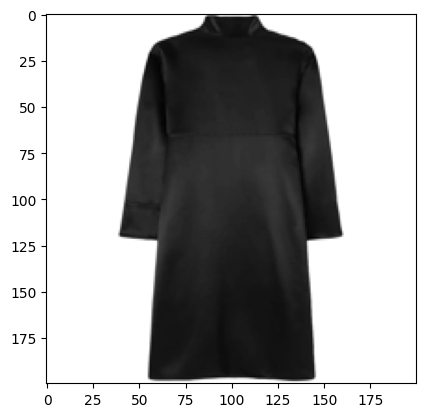

In [5]:
image = x_train[0]
plt.imshow(image, cmap='gray')
plt.show()

In [8]:
# Функция сборки автокодировщика по частям
def create_dense_ae(in_shape, latent_dim): 
    # ЭНКОДЕР
    # Вход
    input_img = Input(in_shape)

    # Вспомогательный слой смены формы
    flat_img = Flatten()(input_img)    
    x = Dense(512, activation='relu')(flat_img)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    # Кодированное полносвязным слоем представление (вектор латентного пространства)
    encoded = Dense(latent_dim, activation='relu')(x)    

    # ДЕКОДЕР
    # Вход
    input_encoded = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(input_encoded)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    # Раскодированное другим полносвязным слоем изображение в виде плоского вектора
    flat_decoded = Dense(in_shape[0] * in_shape[1], activation='sigmoid')(x) 
    
    # Приведение формы раскодированных данных к форме входа
    decoded = Reshape(in_shape)(flat_decoded)

    # Модели, в конструктор первым аргументом передаются входные слои, а вторым выходные слои
    # Другие модели можно так же использовать, как и слои
    encoder = Model(input_img, encoded, name='encoder')
    decoder = Model(input_encoded, decoded, name='decoder')

    # Построение модели автокодировщика (внутри двойное преобразование - сжатие/разжатие)
    autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")

    # Возврат трех собранных моделей
    return encoder, decoder, autoencoder

In [9]:
encoder, decoder, autoencoder = create_dense_ae(in_shape=x_train.shape[1:3], latent_dim=12)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=10,
                validation_data = (x_train, x_train))


ValueError: ignored

In [ ]:
images = x_train
codes = encoder.predict(images) 
assert len(codes) == len(images)

from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"
    code = encoder.predict(image[None])    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    return distances,images[idx]
def show_similar(image):
    distances,neighbors = get_similar(image,n_neighbors=12)
    plt.figure(figsize=[16,14])
    plt.subplot(1,4,1)
    plt.imshow(image, cmap='gray')
    plt.title("Выбранное изображение")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        plt.imshow(neighbors[i], cmap='gray')
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
show_similar(x_train[1])
show_similar(x_train[51])
show_similar(x_train[101])
show_similar(x_train[151])
show_similar(x_train[201])
show_similar(x_train[251])
show_similar(x_train[301])
show_similar(x_train[351])
show_similar(x_train[401])
show_similar(x_train[451])
show_similar(x_train[501])
show_similar(x_train[551])